In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Logistic Regression library
from sklearn.linear_model import LogisticRegression

# Libraries to scale the data
from sklearn.preprocessing import StandardScaler

# Cross Validation
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.decomposition import PCA

# Bayesian Optimization libraries
from functools import partial
from skopt import gp_minimize
from skopt import space
from sklearn import model_selection

from sklearn import ensemble

# Performance Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

# Ignores runtime warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

%matplotlib inline

### Analysis on K-means Imputed and Outlier handled dataset

In [2]:
df1 = pd.read_csv("../processed-datasets/data_outliers_handled_knn_imputed.csv")

In [3]:
df1.head()

,Unnamed: 0,age_ma,Feature,Ti,La,Ce,Pr,Nd,Sm,Eu,...,Dy,Ho,Er,Tm,Yb,Lu,Y,Hf,U,Th
0,0,222.0,0.0,7.88,0.050,10.500,0.050,4.25000,11.60000,1.99000,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2737.00000,12390.0,305.0,134.0
1,1,222.0,0.0,10.90,1.555,61.505,0.725,7.74125,12.56125,2.64375,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2804.03875,12591.0,503.0,272.0
2,2,222.0,0.0,6.00,0.020,25.100,0.300,4.41000,12.56125,2.30000,...,259.21625,106.1375,437.54375,97.8675,936.725,172.63875,2804.03875,12724.0,639.0,414.0
3,3,222.0,0.0,9.06,0.280,12.000,0.070,1.88000,5.08000,1.01000,...,194.00000,83.0000,356.00000,89.5000,762.000,144.00000,1832.00000,12894.0,308.0,127.0
4,4,222.0,0.0,4.93,0.070,16.500,0.150,2.32000,8.23000,1.52000,...,257.00000,106.1375,437.54375,97.8675,936.000,171.00000,2355.00000,12535.0,348.0,155.0


In [4]:
df1.drop('Unnamed: 0', axis=1, inplace=True)

In [5]:
df1.sample(5)

,age_ma,Feature,Ti,La,Ce,Pr,Nd,Sm,Eu,Gd,...,Dy,Ho,Er,Tm,Yb,Lu,Y,Hf,U,Th
1219,839.3875,0.0,7.84,0.080,22.08,0.080,1.13000,1.38000,0.34000,7.510,...,30.29,10.75,50.18,11.50,140.25,20.02,346.45,8732.29,112.87,59.04
1030,123.1900,0.0,4.32,1.555,59.50,0.725,4.56000,3.02000,0.78000,14.020,...,64.24,26.32,132.29,31.80,332.48,68.48,848.89,9060.78,320.67,330.89
1022,134.7900,0.0,23.76,0.190,40.44,0.700,7.74125,12.56125,2.64375,63.555,...,217.22,73.16,297.60,60.82,547.98,100.53,2118.16,7534.91,246.19,465.44
1599,16.0000,1.0,6.70,0.010,43.60,0.110,1.78000,3.59000,1.41000,17.300,...,66.00,24.40,123.00,25.90,254.00,57.80,810.00,8850.00,408.00,385.00
1042,108.4300,0.0,4.55,0.660,43.62,0.240,1.20000,1.63000,0.54000,10.990,...,51.24,20.83,105.39,23.92,252.52,49.75,688.24,9555.18,237.97,232.92


In [6]:
X = df1.drop('Feature', axis=1).values
y = df1.Feature.values

### Splitting the dataset

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

### Scaling the data using Standard Scaler

In [8]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
X_train_scaled.shape

(2390, 20)

### Fitting the base model

In [10]:
rf_base = ensemble.RandomForestClassifier()

rf_base.fit(X_train_scaled, y_train)

RandomForestClassifier()

In [11]:
y_pred = rf_base.predict(X_test_scaled)

In [12]:
print("Accuracy of test set on base model: ", round(accuracy_score(y_test, y_pred), 3))

Accuracy of test set on base model:  0.948


In [13]:
print("Classification report of test set: \n\n", classification_report(y_test, y_pred))

Classification report of test set: 

               precision    recall  f1-score   support

         0.0       0.96      0.95      0.95       338
         1.0       0.94      0.94      0.94       260

    accuracy                           0.95       598
   macro avg       0.95      0.95      0.95       598
weighted avg       0.95      0.95      0.95       598



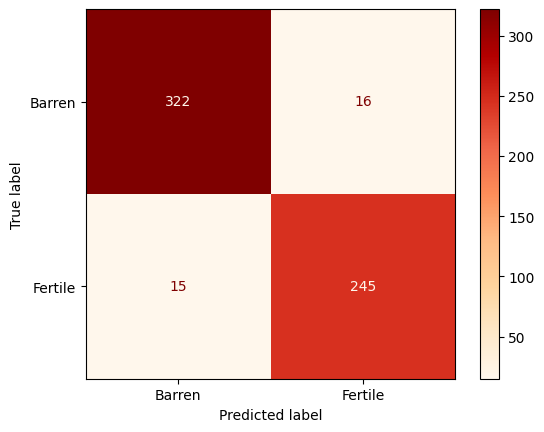

In [14]:
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot(cmap = 'OrRd')

### Hyper-Parameter Tuning

### Grid Search Optimization with stratified K-fold Cross Validation

In [15]:
Stratified_kf = StratifiedKFold(n_splits=10, shuffle=True)

In [16]:
param_grid = {
    
    'max_depth': np.arange(3, 15, 2),
    'n_estimators': np.arange(100, 500, 100),
    'criterion': ['gini', 'entropy'],
    'max_features': ['sqrt', 'log2']
    
}

In [17]:
clf = GridSearchCV(estimator = ensemble.RandomForestClassifier(), 
                   param_grid=param_grid, 
                   scoring='accuracy',
                   cv = Stratified_kf, 
                   n_jobs=-1, 
                   verbose=2, 
                   return_train_score=True)

In [18]:
clf.fit(X_train_scaled, y_train)

Fitting 10 folds for each of 96 candidates, totalling 960 fits


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 3,  5,  7,  9, 11, 13]),
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': array([100, 200, 300, 400])},
             return_train_score=True, scoring='accuracy', verbose=2)

In [19]:
clf.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=11, n_estimators=200)

In [20]:
print("Best Validation set accuracy: ", round(clf.best_score_, 2))

Best Validation set accuracy:  0.96


In [21]:
clf.best_params_

{'criterion': 'entropy',
 'max_depth': 11,
 'max_features': 'sqrt',
 'n_estimators': 200}

In [22]:
y_pred_best = clf.predict(X_test_scaled)

In [23]:
print("Accuracy of test data - GridSearch CV: ", round(accuracy_score(y_test, y_pred_best), 3))

Accuracy of test data - GridSearch CV:  0.945


In [24]:
print("Classification report for test data - Gridsearch CV: \n\n", classification_report(y_test, y_pred_best))

Classification report for test data - Gridsearch CV: 

               precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       338
         1.0       0.93      0.95      0.94       260

    accuracy                           0.94       598
   macro avg       0.94      0.95      0.94       598
weighted avg       0.95      0.94      0.94       598



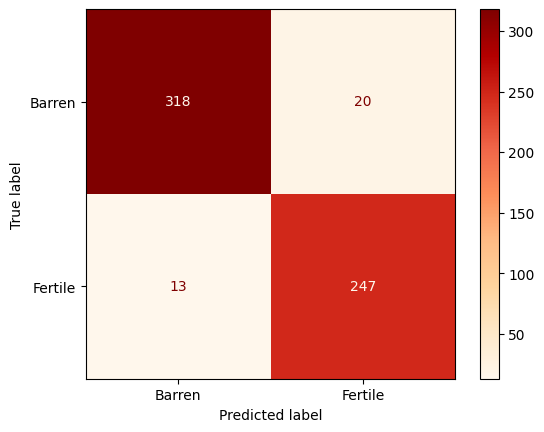

In [25]:
cm = confusion_matrix(y_test, y_pred_best)

ConfusionMatrixDisplay(cm, display_labels=['Barren', 'Fertile']).plot(cmap = 'OrRd')

### Hyper-Parameter Tuning using Bayesian Optimization

In [26]:
def optimize(params, param_names, x, y):
    params = dict(zip(param_names, params))
    model = ensemble.RandomForestClassifier(**params)
    kfold = model_selection.StratifiedKFold(n_splits=10)
    accuracies = []
    
    for idx in kfold.split(X=x, y=y):
        train_idx, valid_idx = idx[0], idx[1]        
        xtrain = x[train_idx]
        ytrain = y[train_idx]
        
        xvalid = x[valid_idx]
        yvalid = y[valid_idx]
        
        model.fit(xtrain, ytrain)        
        preds = model.predict(xvalid)        
        fold_accuracy = accuracy_score(yvalid, preds)
        
        accuracies.append(fold_accuracy)
        
    return -1.0 * np.mean(accuracies)

In [27]:
param_space = [
    space.Integer(3, 13, name='max_depth'),
    space.Integer(100, 500, name='n_estimators'),
    space.Categorical(categories=['gini', 'entropy'], name='criterion'),
    space.Categorical(['sqrt', 'log2'], name='max_features')
]

In [28]:
param_names = ['max_depth', 'n_estimators', 'criterion',  'max_features']

In [29]:
optimization_function = partial(optimize, param_names = param_names, x = X_train_scaled, y = y_train)

In [30]:
result = gp_minimize(func=optimization_function,
                     dimensions = param_space,
                     n_calls=10,
                     n_random_starts=5,
                     verbose=10,
                     n_jobs=-1)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 7.7080
Function value obtained: -0.9234
Current minimum: -0.9234
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 13.3212
Function value obtained: -0.9469
Current minimum: -0.9469
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.8887
Function value obtained: -0.9515
Current minimum: -0.9515
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 21.0533
Function value obtained: -0.9594
Current minimum: -0.9594
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 13.2871
Function value obtained: -0.9569
Current minimum: -0.9594
Iteration No: 6 start

In [31]:
best_params_bayesian = dict(zip(param_names, result.x))
print(best_params_bayesian)

{'max_depth': 11, 'n_estimators': 500, 'criterion': 'entropy', 'max_features': 'log2'}


In [32]:
best_model_rf_bayesian = ensemble.RandomForestClassifier(**best_params_bayesian)

In [33]:
best_model_rf_bayesian.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=11, max_features='log2',
                       n_estimators=500)

In [34]:
y_preds_best_bayesian = best_model_rf_bayesian.predict(X_test_scaled)

In [35]:
print("Accuracy of test data using Bayesian Optimization: ", round(accuracy_score(y_test, y_preds_best_bayesian), 3))

Accuracy of test data using Bayesian Optimization:  0.943


In [36]:
print("Classification report for test data - Gridsearch CV: \n\n", classification_report(y_test, y_preds_best_bayesian))

Classification report for test data - Gridsearch CV: 

               precision    recall  f1-score   support

         0.0       0.96      0.94      0.95       338
         1.0       0.92      0.95      0.94       260

    accuracy                           0.94       598
   macro avg       0.94      0.94      0.94       598
weighted avg       0.94      0.94      0.94       598



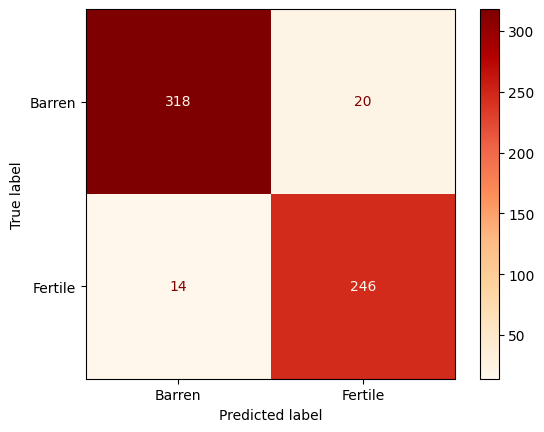

In [37]:
cm_bayesian = confusion_matrix(y_test, y_preds_best_bayesian)

ConfusionMatrixDisplay(cm_bayesian, display_labels=['Barren', 'Fertile']).plot(cmap = 'OrRd')

### Plotting the decision boundary

In [38]:
input_features = X_test_scaled.copy()
output_feature = y_test.copy()

In [39]:
pca = PCA(n_components = 2)

X_reduced = pca.fit_transform(input_features)

In [40]:
X_reduced.shape

(598, 2)

In [41]:
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

In [42]:
def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

In [43]:
plot_model = ensemble.RandomForestClassifier(**best_params_bayesian)

plot_model.fit(X_reduced, output_feature)

RandomForestClassifier(criterion='entropy', max_depth=11, max_features='log2',
                       n_estimators=500)

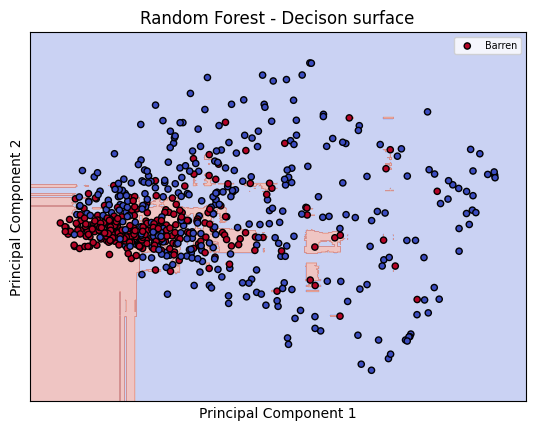

In [44]:
fig, ax = plt.subplots(facecolor='white')

# title for the plots
title = ('Decision surface of Tuned Random Forest')

# Set-up grid for plotting.
X0, X1 = X_reduced[:, 0], X_reduced[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, plot_model, xx, yy, cmap=plt.cm.coolwarm, alpha=0.3) # alpha=0.8
ax.scatter(X0, X1, c=y_test, edgecolors='k', cmap=plt.cm.coolwarm, s=20)
ax.set_ylabel('Principal Component 2')
ax.set_xlabel('Principal Component 1')
ax.set_xticks(())
ax.set_yticks(())
ax.set_title('Random Forest - Decison surface')
ax.legend(labels=['Barren', 'Fertile'], fontsize="x-small")
plt.show()

### Save the Best Performing Model

In [45]:
import pickle

with open('../Best model pickle files/random_forest_best.pkl', 'wb') as f:
    pickle.dump(plot_model, f)

In [46]:
with open('../Best model pickle files/random_forest_best.pkl', 'rb') as f:
    clf_loaded = pickle.load(f)

In [47]:
clf_loaded

RandomForestClassifier(criterion='entropy', max_depth=11, max_features='log2',
                       n_estimators=500)

[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200; total time=   0.9s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300; total time=   1.3s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400; total time=   1.7s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400; total time=   1.7s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=200; total time=   0.8s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=300; total time=   1.3s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=400; total time=   1.7s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=400; total time=   1.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=200; total time=   1.1s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_e

[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200; total time=   0.9s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300; total time=   1.3s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400; total time=   1.7s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400; total time=   1.7s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=200; total time=   0.8s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=300; total time=   1.2s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=400; total time=   1.7s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_e

[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200; total time=   0.9s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300; total time=   1.3s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400; total time=   1.7s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=100; total time=   0.4s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=200; total time=   0.8s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=300; total time=   1.3s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_e

[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=100; total time=   0.5s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=200; total time=   0.9s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300; total time=   1.3s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=300; total time=   1.3s
[CV] END criterion=gini, max_depth=3, max_features=sqrt, n_estimators=400; total time=   1.7s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=200; total time=   0.8s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=200; total time=   0.9s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=300; total time=   1.3s
[CV] END criterion=gini, max_depth=3, max_features=log2, n_estimators=400; total time=   1.7s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_estimators=100; total time=   0.6s
[CV] END criterion=gini, max_depth=5, max_features=sqrt, n_e